# SedGen: examples

## Imports

In [11]:
import numpy as np
import numba as nb
from numba.typed import List
import numexpr as ne
import pandas as pd
import itertools
from operator import itemgetter
import gc
import copy

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [2]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing

In [3]:
%load_ext line_profiler
%load_ext memory_profiler

In [4]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

## Model input
___

### Parent rock characteristics

In [5]:
# Unit is mm³
parent_rock_volume = 1e9

# Mineral classes present in parent rock
minerals = ["Q", "P", "K", "B", "O", "A"]

### Modal mineralogy
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [6]:
# Modal mineralogy mean values f CA-NS of Heins(1992)
modal_mineralogy = np.array([0.30591989, 0.38159713, 0.26209888, 0.01882560, 0.00799247, 0.02356603])

### Interfacial composition
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [7]:
interface_proportions_true = None

### Crystal size distributions
This property will be based on a mean crystal size and standard deviation  
which will be represented as a log-normal distribution.

In [8]:
csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

## Initialization

In [109]:
%%time
sedgen_CA_NS = SedGen(minerals, 
                      parent_rock_volume, 
                      modal_mineralogy,
                      csds_CA_NS_means, 
                      csds_CA_NS_stds, 
                      learning_rate=10000, 
                      timed=True)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.2767 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.0978 seconds
Counting interfaces...  Done in 0.0346 seconds
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2670 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,

## Mechanical Weathering

In [112]:
sedgen_CA_NS_mech = sedgen_CA_NS.weathering(operations=["intra_cb", "inter_cb"], timesteps=100, inplace=False)

After 81 steps all pcgs have been broken down to mcg


C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


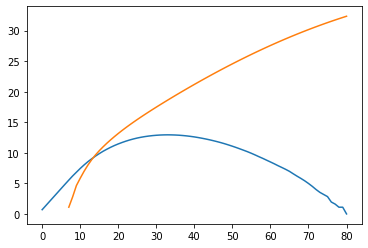

In [113]:
plt.plot(np.log(sedgen_CA_NS_mech.pcg_additions))
plt.plot(np.log(sedgen_CA_NS_mech.mcg_additions))
pass;

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


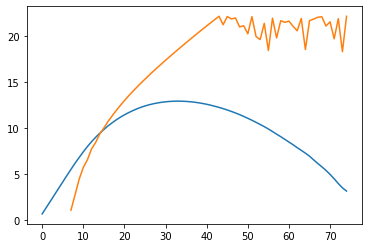

In [93]:
plt.plot(np.log(sedgen_CA_NS_mech.pcg_additions))
plt.plot(np.log(sedgen_CA_NS_mech.mcg_additions))
pass;

In [65]:
np.sum(sedgen_CA_NS_mech.mcg[0][0][:1000])

3311106970

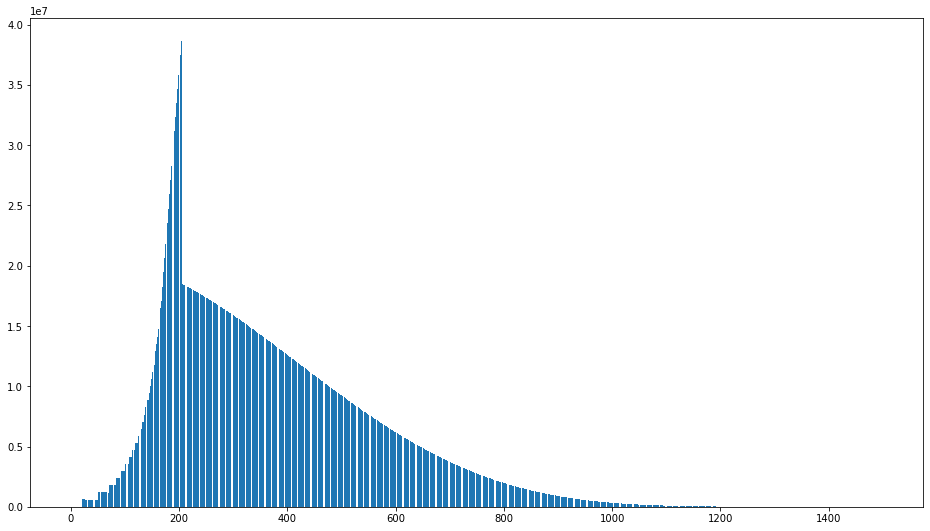

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0]);

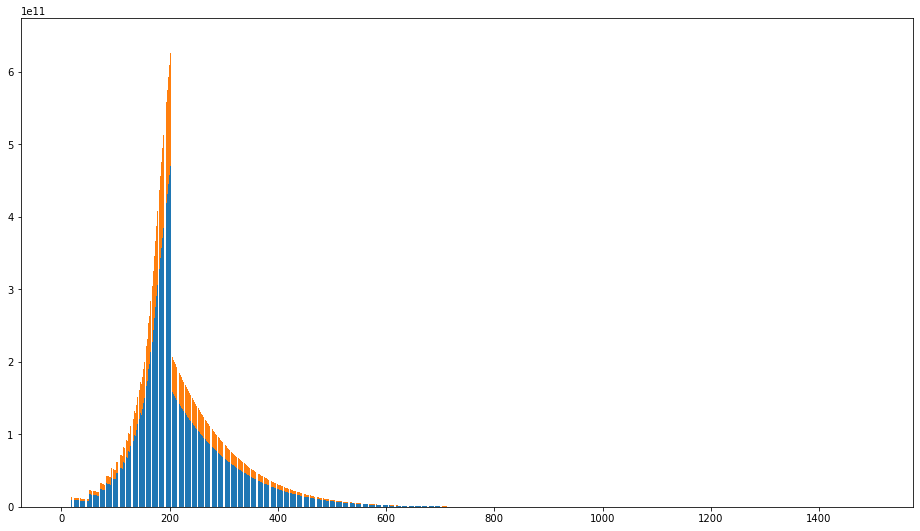

In [134]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0], zorder=10)
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][1])
plt.savefig("test.pdf")
plt.show();

<BarContainer object of 1500 artists>

<BarContainer object of 1500 artists>

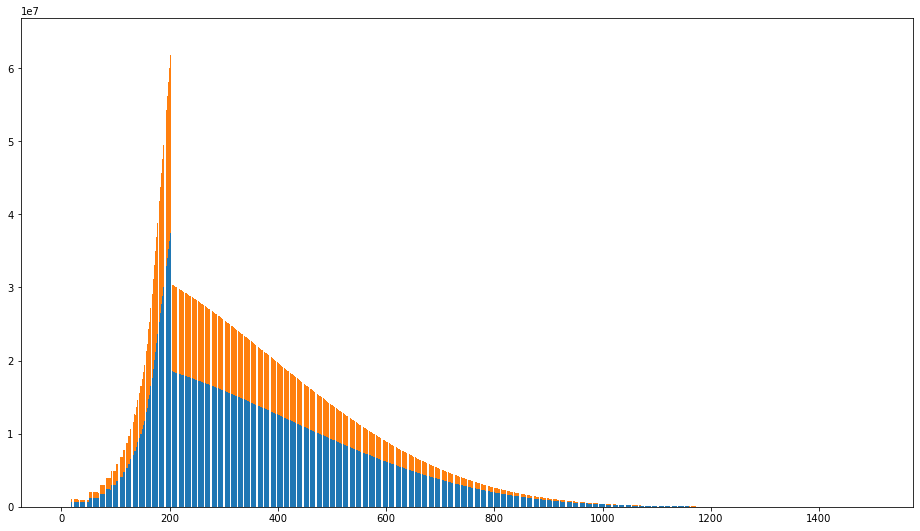

In [76]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0], zorder=10)
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][1])
plt.savefig("test.pdf")
plt.show();

In [116]:
2**-4

0.0625

In [120]:
sedgen_CA_NS_mech.size_bins[1100]

2.0

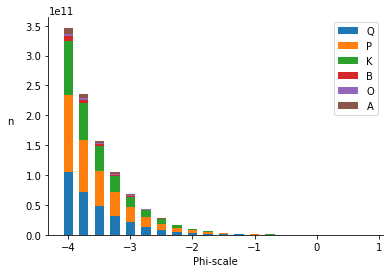

In [172]:
for d in range(600, 1100, 25):
    heights = np.sum(sedgen_CA_NS_mech.mcg[0, :, d:d+100], axis=1)
    for m in range(6):
        if d == 600:
            plt.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            plt.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
plt.legend()
ax.set_xlabel([4, 3, 2, 1, 0, -1])
sns.despine()

plt.xlabel("Phi-scale")
plt.ylabel("n", rotation=0, labelpad=15)

plt.show();

## Chemical Weathering

In [173]:
sedgen_CA_NS_chem = sedgen_CA_NS.weathering(operations=["chem_mcg", "chem_pcg"], timesteps=100, inplace=False)

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


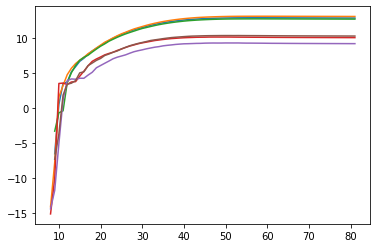

In [175]:
plt.plot(np.log(sedgen_CA_NS_mech.residue_additions))
pass;